In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
%matplotlib inline

In [23]:
from pyspark.sql import SparkSession
# Spark session & context
spark = SparkSession.builder.master('local[*]') \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()
sc = spark.sparkContext

21/07/04 13:18:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [24]:
df_raw = spark.read.format("parquet").load("data/train")

In [25]:
df_raw.createOrReplaceTempView("df_raw")

21/07/04 13:18:27 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


# Сформировать критерии оттекших/удержавшихся пользователей

In [26]:
# посмотрим на список колонок

for col in df_raw.columns:
    print(col)


instanceId_userId
instanceId_objectType
instanceId_objectId
audit_pos
audit_clientType
audit_timestamp
audit_timePassed
audit_experiment
audit_resourceType
metadata_ownerId
metadata_ownerType
metadata_createdAt
metadata_authorId
metadata_applicationId
metadata_numCompanions
metadata_numPhotos
metadata_numPolls
metadata_numSymbols
metadata_numTokens
metadata_numVideos
metadata_platform
metadata_totalVideoLength
metadata_options
relationsMask
userOwnerCounters_USER_FEED_REMOVE
userOwnerCounters_USER_PROFILE_VIEW
userOwnerCounters_VOTE_POLL
userOwnerCounters_USER_SEND_MESSAGE
userOwnerCounters_USER_DELETE_MESSAGE
userOwnerCounters_USER_INTERNAL_LIKE
userOwnerCounters_USER_INTERNAL_UNLIKE
userOwnerCounters_USER_STATUS_COMMENT_CREATE
userOwnerCounters_PHOTO_COMMENT_CREATE
userOwnerCounters_MOVIE_COMMENT_CREATE
userOwnerCounters_USER_PHOTO_ALBUM_COMMENT_CREATE
userOwnerCounters_COMMENT_INTERNAL_LIKE
userOwnerCounters_USER_FORUM_MESSAGE_CREATE
userOwnerCounters_PHOTO_MARK_CREATE
userOwnerCoun

In [27]:
# посмотрим минимальное, максимальное значение даты и разницу между ними
spark.sql("""
    select min(date), max(date), datediff(max(date), min(date))
    from df_raw
""").show()

+----------+----------+------------------------------+
| min(date)| max(date)|datediff(max(date), min(date))|
+----------+----------+------------------------------+
|2018-02-01|2018-03-21|                            48|
+----------+----------+------------------------------+



#### будем считать, что если пользователь не совершал никаких действий более трех недель, то он уже и не вернется

In [28]:
df_tgt = spark.sql("""
with cte_last_action as (
    select instanceId_userId, max(date) as md from df_raw group by instanceId_userId
)
, cte_target as (
    select 
        instanceId_userId
        , case when datediff('2018-03-21', md) > 21 then 1 else 0 end as target
    from cte_last_action
) select e.*, t.target from df_raw e
    join cte_target t on e.instanceId_userId = t.instanceId_userId
""")

df_tgt.createOrReplaceTempView("df_tgt")

In [29]:
# посмотрим сколько у нас получилось оттёкших пользователей
spark.sql("""
    select target, count(*) from df_tgt group by target
""").show()

+------+--------+
|target|count(1)|
+------+--------+
|     1| 1925038|
|     0|16361537|
+------+--------+



# Подготовить признаки, обучить модель

Выдвинем гипотезу, что отток напрямую зависит либо от общего кол-ва взаимодействий с пабликами в течение последних Х недель, или же от каких-то конкретных взаимодействий в течение последних Х недель

In [ ]:
# расширим наш врейм, вытащив список реакций в каждую отдельную строку

df_exp_tgt = spark.sql("""
    select 
        instanceId_userId
        , explode(feedback) as fb_exp 
        , date
        , target
    from df_tgt t 
""")
df_exp_tgt.createOrReplaceTempView("df_exp_tgt")

In [ ]:
# разобьем разницу между датой действия и последней даты на группы с шагом 3
# , чтобы на выходе можно было посчитать кол-во действий в ретроспективе
# , сгруппировав их по этим "лагам времени" и типам реакций

df_bucket = spark.sql("""
    select 
        instanceId_userId
        , explode(feedback) as fb_exp 
        , floor(datediff('2018-03-21',date) / 3) date_diff_bucket
        , target
    from df_tgt t 
    order by date
""")

df_bucket.createOrReplaceTempView("df_bucket")

In [ ]:
# сделаем фрейм с разбивкой по типу действия + недельному лагу

df_act_type_lag = spark.sql("""
select 
    instanceId_userId
    , concat(fb_exp, '_', date_diff_bucket) as act_type
    , target
from df_bucket
""")

df_pivot_act_type = df_act_type_lag\
    .groupBy("instanceId_userId")\
    .pivot("act_type")\
    .count()\
    .na.fill(0)

df_pivot_act_type.createOrReplaceTempView("df_pivot_act_type")

# сделаем фрейм с разбивкой по недельному лагу
df_lag = spark.sql("""
select 
    instanceId_userId
    , concat('total_', date_diff_bucket) as total_lag
    , target
from df_bucket
""")

df_pivot_lag = df_lag\
    .groupBy("instanceId_userId")\
    .pivot("total_lag")\
    .count()\
    .na.fill(0)

df_pivot_lag.createOrReplaceTempView("df_pivot_lag")


In [ ]:
# объединим это всё в один фрейм

df_for_split = spark.sql("""
    select 
        -- pa.*
        --, la.total_0 
        --, la.total_1
        --, la.total_2
        --, la.total_3
        --, la.total_4
        --, la.total_5
        --, la.total_6
        la.*
        , t.target
    from df_tgt t
    -- left join df_pivot_act_type pa on t.instanceId_userId = pa.instanceId_userId
    left join df_pivot_lag la on t.instanceId_userId = la.instanceId_userId
""")

#### Таким образом, получили разряженную матрицу с кол-ом реакций, разбитых по неделям и по типам + неделям. 

In [ ]:
pdf_for_split = df_for_split.toPandas()
'''
df_for_split.coalesce(1) \
      .write \
      .option("header","true") \
      .option("sep",",") \
      .mode("overwrite") \
      .csv("train_pivot.csv")
'''

In [2]:
# давайте посмотрим, что у нас в итоге получилось
pdf_for_split = pd.read_csv("train_pivot.csv/part-00000-4ca47e80-0bb8-47e5-999d-4e076dcb4ebb-c000.csv")

In [3]:
corr = pdf_for_split.corr()

<AxesSubplot:>

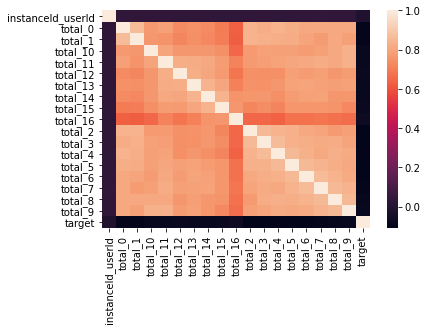

In [4]:
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

<img src="Corr_heatmap.png">

Корреляция между признаками есть и достаточно высокая, однако она никакая между признаками и целевой переменной. Что странно, казалось, что последние недели должны быть сильно скоррелированы с целевой переменной. Ну да ладно, обучим модель и посмотрим на результаты.

In [5]:
import sys
!{sys.executable} -m pip install xgboost
import xgboost

     |████████████████████████████████| 166.7 MB 951 kB/s eta 0:00:01   |█▋                              | 8.6 MB 5.5 MB/s eta 0:00:29     |█▉                              | 9.6 MB 5.5 MB/s eta 0:00:29     |███                             | 16.1 MB 5.4 MB/s eta 0:00:28     |█████▉                          | 30.6 MB 1.0 MB/s eta 0:02:14     |███████▊                        | 40.5 MB 884 kB/s eta 0:02:23     |████████                        | 41.3 MB 884 kB/s eta 0:02:22     |██████████████▋                 | 76.3 MB 902 kB/s eta 0:01:41     |██████████████▊                 | 76.6 MB 902 kB/s eta 0:01:40     |██████████████▉                 | 77.2 MB 902 kB/s eta 0:01:40     |███████████████▎                | 79.3 MB 1.1 MB/s eta 0:01:18     |██████████████████              | 94.2 MB 879 kB/s eta 0:01:23     |██████████████████▏             | 94.6 MB 1.2 MB/s eta 0:01:01     |████████████████████▏           | 104.9 MB 1.2 MB/s eta 0:00:54     |███████████████████████▌        | 122.3 MB 8

In [6]:
features = ['total_1', 'total_2', 'total_3', 'total_4', 'total_5', 'total_6', 
            'total_7', 'total_8', 'total_9', 'total_10', 'total_11', 'total_12', 
            'total_13', 'total_14', 'total_15', 'total_16']

X = pdf_for_split[features]
y = pdf_for_split['target']

In [7]:
# Разобьем датасет на трейн и тест
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [8]:
# Обучим модель из коробки
model = xgboost.XGBClassifier().fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:23:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [9]:
test_pred = model.predict(X_test)

In [10]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, test_pred)

array([[5255867,  142934],
       [  17284,  618485]])

In [11]:
from sklearn.metrics import f1_score
f1_score(y_test, test_pred)

0.8853282450178502

Значение f1_score = 0.8853282450178502 - что есть очень даже не плохо, особенно для модели из коробки.

# Интерпретируем модель, сделать сегментацию пользователей.

In [12]:
print(model.feature_importances_)

[0.15085818 0.20469584 0.14430043 0.17565031 0.18231624 0.1336763
 0.00293394 0.00093219 0.00075878 0.00059899 0.00063925 0.00033791
 0.00059512 0.00079652 0.00059846 0.00031149]


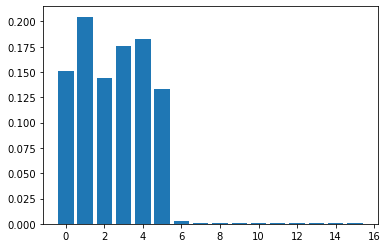

In [13]:
from matplotlib import pyplot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

<img src="feature_importances.png">

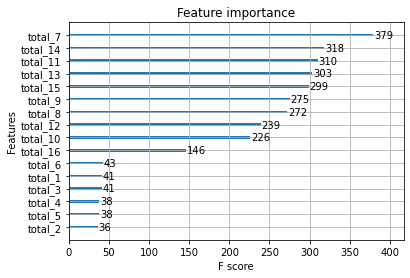

In [14]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import plot_importance
# plot feature importance
plot_importance(model)
pyplot.show()

<img src="plot_importance.png">

Несмотря на то, что при расчёте корреляции не было видно зависимости целевой переменной от данных за последние три недели (total_1 - total_6), оценка ценности фичей XGBoost нам показывает ровно то, что мы ожидали увидеть - он принимает решение на основе ожидаемых нами фичей.

In [15]:
# нормализуем данные
scaler = StandardScaler()
scaler.fit(X)
X_norm = scaler.transform(X)


Calculating data for n_clusters=1
Calculating data for n_clusters=2
Calculating data for n_clusters=3
Calculating data for n_clusters=4
Calculating data for n_clusters=5
Calculating data for n_clusters=6
Calculating data for n_clusters=7
Calculating data for n_clusters=8
Calculating data for n_clusters=9
Calculating data for n_clusters=10


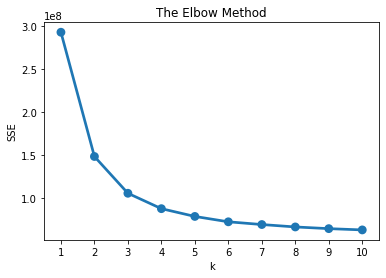

In [16]:
# воспользуемся методом локтя, чтобы определить кол-во кластеров
sse = {}
for k in range(1, 11):
    print(f'Calculating data for n_clusters={k}')
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_norm)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
    
# отрисуем результат
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

<img src="elbow.png">

Как можно заметить на графике, при значении кол-ва кластеров болше 3х выходим на плато, следовательно будем делить пользователей на 3 кластера.

In [17]:
# кластеризуем пользователей
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_norm)

KMeans(n_clusters=3, random_state=42)

In [18]:
# посчитаем средние по кластерам
X['Cluster'] = kmeans.labels_
X_cc = X.groupby('Cluster').agg({
    'total_1':'mean'
    , 'total_2':'mean'
    , 'total_3':'mean'
    , 'total_4':'mean'
    , 'total_5':'mean'
    , 'total_6':'mean'
    , 'total_7':'mean'
    , 'total_8':'mean'
    , 'total_9':'mean'
    , 'total_10':'mean'
    , 'total_11':'mean'
    , 'total_12':'mean'
    , 'total_13':'mean'
    , 'total_14':'mean'
    , 'total_15':'mean'
    , 'total_16':'mean'
}).round(2)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [19]:
X_cc

,total_1,total_2,total_3,total_4,total_5,total_6,total_7,total_8,total_9,total_10,total_11,total_12,total_13,total_14,total_15,total_16
Cluster,,,,,,,,,,,,,,,,
0,70.16,67.34,70.13,71.81,72.46,69.98,68.88,70.08,69.45,44.61,65.58,43.93,62.43,62.30,60.23,21.68
1,1.20,1.20,1.25,1.20,1.26,1.24,1.18,1.22,1.19,0.84,1.17,0.78,1.14,1.16,1.14,0.35
2,18.62,18.83,19.01,19.02,19.75,19.21,19.18,18.64,19.24,13.10,18.88,12.57,18.65,18.39,17.80,5.85


In [21]:
# построим графики для более наглядного представления данных по кластерам

df_nor_melt = pd.melt(
    X_cc.reset_index(),
    id_vars=['Cluster'],
    value_vars=features,
    var_name='Attribute',
    value_name='Value'
)
df_nor_melt.head()

,Cluster,Attribute,Value
0,0,total_1,70.16
1,1,total_1,1.20
2,2,total_1,18.62
3,0,total_2,67.34
4,1,total_2,1.20


<AxesSubplot:xlabel='Attribute', ylabel='Value'>

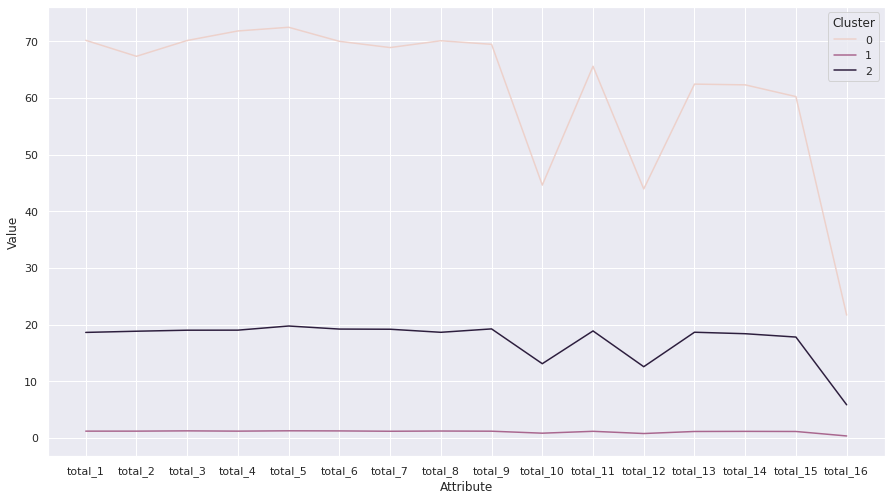

In [22]:
sns.set(rc={'figure.figsize':(15,8.27)})
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=df_nor_melt, markers=True, dashes=False)

<img src="clusters.png">

Наших пользователей явно можно поделить на 3 группы:
* Высоко активные пользователи, в среднем взаимодействуют с группами около 60 раз в течение трех дней (Cluster 0)
* Средне активные пользователи, в среднем взаимодействуют с группами около 18 раз в течение трех дней (Cluster 2)
* Изначально мертвые пользователи, которые вообще практически не взаимодействуют с группами (Cluster 1)

# Выдвигаем гипотезы

На мой взгляд это всё будет "пальцем в небо" т.к. никакого контекста мы не имеем, а без него генерить идеи немного проблематично =) Но все же попробуем. 

Посольку наш кластер "Cluster 1" отображает пользователей, которые, судя по всему, даже не начинают взаимодействовать с постами\группами, можно предположить следующее:

* Пользователи регистрируются, но не могут разобраться в интефейсе и уходят. Данная проблема может вылечиться онбордингом. Можно сделать небольшой процесс обучения, который подсветит для пользователя основные элементы интерфейса и кратко опишет как проходить тот или иной процесс поиска групп \ событий \ друзей и т.д.

* Пользователи регистрируются, интерфейс им понятен, но они не могут найти интересующие их группы. В данном случае можно попробовать улучшить поисковый механизм, например при помощи Elasticsearch. Далеко не все пользователи пишут грамотно, они могут допускать опечатки или использовать синонимы \ жаргонные слова при поиске. При помощи Elasticsearch можно покрыть все эти кейсы.

* Пользователи умеют в поиск, пишут грамотно, но им просто лень искать нужные группы. Данную проблему можно попробовать вылечить при помощи рекомендательных систем. В качестве холодного старта можно рекомендовать самые популярные группы среди пользователей того же города \ пола + возраста и т.д. Можно собрать с пользователей их интересы и рекомендовать группы на основе их предпочтений. Кроме того, можно рекомендовать самые популярные группы среди тех, на которые подписаны люди из тех же групп в которых пользователь уже состоит. 